In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO
import pandas as pd
from torch.distributions import constraints
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from preprocessor import YelpData
from pyro.infer.autoguide import init_to_feasible

In [3]:
data_class = YelpData()

In [4]:
# only for first time 
# data_class.process()
# data = torch.from_numpy(data_class.add_bias().astype(np.float32))
# ratings = torch.from_numpy(data_class.ratings.to_numpy().astype(np.float32))
# data_class.to_pickle(data, 'data')
# data_class.to_pickle(ratings, 'ratings')

In [5]:
data = data_class.load('data')/ 10000
ratings = data_class.load('ratings')
num_features = data.shape[1] - 1

In [9]:
def model(data, ratings):
#     betas = []

    #bias
#     betas.append(pyro.sample("beta_0", dist.Normal(0, 1)))
    #make one-hot vector length betas
    with pyro.plate("betas", num_features + 1):
        betas = pyro.sample("beta", dist.Gamma(1,1))
#     for i in range(num_feature):
#         betas.append(pyro.sample("beta_{}".format(i + 1), dist.Normal(0, 1)))

#     betas = torch.from_numpy(np.array(betas))
#     print(betas.dtype)
    lambda_ = torch.exp(torch.sum(betas * data))
#     import pdb
#     pdb.set_trace()
    with pyro.plate("ratings", ratings.shape[0]):
        y = pyro.sample("obs", dist.Poisson(lambda_), obs = ratings)
#     import pdb
#     pdb.set_trace()
    return y
# model(data, ratings)

In [10]:
def guide(data, ratings):
    alphas_0 = pyro.param('weights_loc', torch.ones(546),  constraint=constraints.positive)
    alphas_1 = pyro.param('weights_scale', torch.ones(546), constraint=constraints.positive)        
#     weights_loc = pyro.param('weights_loc', torch.randn(2))
#     weights_scale = pyro.param('weights_scale', torch.ones(2), constraint=constraints.positive)        

    with pyro.plate("betas", num_features + 1):
        betas = pyro.sample("beta", dist.Gamma(alphas_0, alphas_1))
  


In [11]:
# def guide(rating, rating_ns, popularity):
#     weights_loc = pyro.param('weights_loc', torch.randn(3))
#     weights_scale = pyro.param('weights_scale', torch.ones(3), constraint=constraints.positive)        
# #     weights_loc = pyro.param('weights_loc', torch.randn(2))
# #     weights_scale = pyro.param('weights_scale', torch.ones(2), constraint=constraints.positive)        

    
#     beta_0 = pyro.sample("beta_0", dist.Normal(weights_loc[0], weights_scale[0]))
#     beta_1 = pyro.sample("beta_1", dist.Normal(weights_loc[1], weights_scale[1]))
#     beta_2 = pyro.sample("beta_2", dist.Normal(weights_loc[2], weights_scale[2]))
#     labmda_ = torch.exp(beta_0 + beta_1 * rating + beta_2 * rating_ns)
# #     labmda_ = torch.exp(beta_0 + beta_1 * rating)

# guide = pyro.infer.autoguide.AutoDiagonalNormal(model, init_loc_fn=init_to_feasible)
# guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

In [12]:
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

# pyro.clear_param_store()
epoch = 10000
for i in range(epoch):
    ELBO = svi.step(data, ratings)
    if i % 500 == 0:
        print(ELBO)


70459280.0
14424645.0
383846.0
6101869.0
817356.4375
1067403.5
206303.90625
1287025.0
607308.5
378354.375
1997951.5
2112041.0
1875310.75
2056038.75
467686.6875
88704.6875
127718.078125
73377.96875
124374.40625
185939.46875


In [13]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(data, ratings)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 1200/1200 [3:03:59<00:00,  9.75s/it, step size=2.34e-02, acc. prob=0.922] 


In [15]:
#data_class.to_pickle(hmc_samples, 'hmc_samples')

In [16]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


In [21]:
svi_diagnorm_posterior = svi.run(data,ratings)
sites = ["betas"]

svi_samples = {site: EmpiricalMarginal(svi_diagnorm_posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: betas
      mean  std     5%    25%    50%    75%    95%
0      0.0  0.0    0.0    0.0    0.0    0.0    0.0
1      1.0  0.0    1.0    1.0    1.0    1.0    1.0
2      2.0  0.0    2.0    2.0    2.0    2.0    2.0
3      3.0  0.0    3.0    3.0    3.0    3.0    3.0
4      4.0  0.0    4.0    4.0    4.0    4.0    4.0
..     ...  ...    ...    ...    ...    ...    ...
541  541.0  0.0  541.0  541.0  541.0  541.0  541.0
542  542.0  0.0  542.0  542.0  542.0  542.0  542.0
543  543.0  0.0  543.0  543.0  543.0  543.0  543.0
544  544.0  0.0  544.0  544.0  544.0  544.0  544.0
545  545.0  0.0  545.0  545.0  545.0  545.0  545.0

[546 rows x 7 columns] 



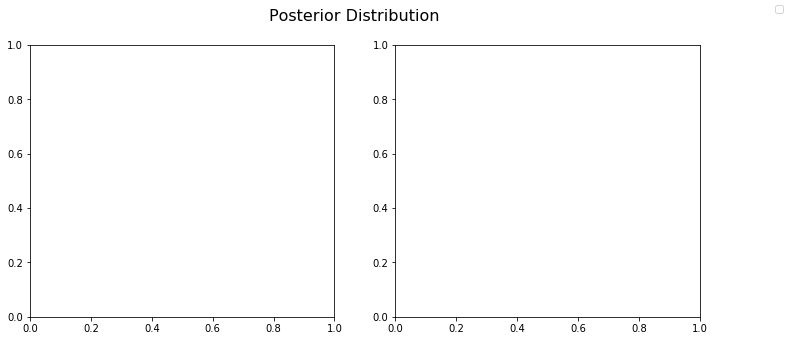

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle("Posterior Distribution", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        site = sites[i]
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
        sns.distplot(svi_samples[site], ax=ax, label="SVI")
        ax.set_title(site)
    except:
        pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [ ]:
# #MLE

# #variables
# MLE_thetas = torch.ones(train_data.shape[1] - 1, requires_grad = True)
# def neg_log_likelihood(x,y):
#     theta_times_x = MLE_thetas * x
#     log_likelihood = torch.sum(y * theta_times_x - torch.exp(theta_times_x))
#     return -log_likelihood

# def get_MLE(x, y):
#     epoch = 10000
#     optimizer = torch.optim.Adam([MLE_thetas])
#     for i in range(epoch):

#         optimizer.zero_grad()
#         target = neg_log_likelihood(x,y)
#         target.backward()
#         optimizer.step()

# get_MLE(train_data[:,:2],train_data[:,2:])

In [ ]:
MLE_thetas

In [9]:
#MLE

#variables
MLE_thetas = torch.ones([548,1], requires_grad = True, dtype = torch.float32)
def neg_log_likelihood(x,y):
#     import pdb
#     pdb.set_trace()
    theta_times_x = torch.matmul(x, MLE_thetas)


    log_likelihood = torch.matmul(y, theta_times_x) + torch.sum(torch.exp(theta_times_x))
#     torch.sum(y * theta_times_x - torch.exp(theta_times_x))
    return -log_likelihood

def get_MLE(x, y):
    epoch = 1000
    optimizer = torch.optim.Adam([MLE_thetas])
    for i in range(epoch):

        optimizer.zero_grad()
        target = neg_log_likelihood(x,y)
#         print(target)
        target.backward()
        optimizer.step()

get_MLE(data, ratings)

In [10]:
MLE_thetas

tensor([[3.5136],
        [4.2317],
        [3.7128],
        [2.7420],
        [1.2363],
        [4.0657],
        [4.3124],
        [3.5248],
        [4.0266],
        [1.2363],
        [3.0732],
        [3.2069],
        [3.5548],
        [1.2363],
        [3.9610],
        [4.2634],
        [4.3900],
        [3.5367],
        [4.2208],
        [4.1062],
        [4.2268],
        [2.2122],
        [4.3321],
        [3.9244],
        [3.9843],
        [4.3715],
        [3.9043],
        [4.1201],
        [2.2122],
        [3.2042],
        [3.0741],
        [4.5127],
        [3.0742],
        [4.0018],
        [3.3578],
        [4.1247],
        [3.5959],
        [4.2773],
        [4.3532],
        [4.1354],
        [1.2363],
        [2.3087],
        [2.3087],
        [4.1038],
        [4.0225],
        [3.9273],
        [4.3853],
        [3.9795],
        [3.9377],
        [3.3540],
        [3.1862],
        [3.8257],
        [2.7416],
        [4.2225],
        [2.7477],
        [3